In [1]:
import numpy as np
import enum
import time
import matplotlib.pyplot as plt
import sympy as sp
from sympy import cos, sin, exp
from solver_linear import Solver

plt.style.use("ggplot")

In [ ]:
import sympy as sp

variables = [sp.Symbol('x'), sp.Symbol('y'), sp.Symbol('z')]
x = variables[0]
y = variables[1]
z = variables[2]

class Method(enum.Enum):
    '''
        Перечисление для удобного выбора метода
    '''
    DICHOTOMY   = 1
    NEWTON      = 2
    ITER_SIMPLE = 3

class Solver_non_linear:
    """
        Решатель СНЛАУ
    """

    def dichotomy(self, f, x_l, x_r, epsilon=10e-6):
        if(np.sign(f(x_l)) == np.sign(f(x_r))):
            raise RuntimeError("Значения на концах отрезка должны быть разного знака")

        while(True):
            x_m = (x_l + x_r) / 2
            if np.abs(f(x_m) - 0) < epsilon:
                return x_m
            if(np.sign(f(x_l)) != np.sign(f(x_m))):
                x_r = x_m
            elif(np.sign(f(x_m)) != np.sign(f(x_r))):
                x_l = x_m

    def __calc_J(self, f, x_):
        dim = len(f)
        ans = np.zeros((dim, dim))
        if(dim == 1):
            x_value = {x: x_[0]}
            return  np.array([f[0][0].subs(x_value)])
        if(dim == 2):
            x_value = {x: x_[0], y: x_[1]}
        if(dim == 3):
            x_value = {x: x_[0], y: x_[1], z: x_[2]}
        for i in range(dim):
            for j in range(dim):
                ans[i, j] = f[i][j].subs(x_value)

        return ans

    def __calc_F(self, F, x_):    
        dim = len(F)
        if(dim == 1):
            F_num = sp.lambdify([x], F[0], 'numpy')
            return np.array(F_num(x_[0]))
        if(dim == 2):
            F_num_1 = sp.lambdify([x, y], F[0], 'numpy')
            F_num_2 = sp.lambdify([x, y], F[1], 'numpy')
            return np.array([F_num_1(x_[0], x_[1]), F_num_2(x_[0], x_[1])])
        if(dim == 3):
            F_num_1 = sp.lambdify([x, y, z], F[0], 'numpy')
            F_num_2 = sp.lambdify([x, y, z], F[1], 'numpy')
            F_num_3 = sp.lambdify([x, y, z], F[2], 'numpy')
            return np.array([F_num_1(x_[0], x_[1], x_[2]), F_num_2(x_[0], x_[1], x_[2]), F_num_3(x_[0], x_[1], x_[2])])

    def NEWTON(self, F, x0, max_iter=100, epsilon=1e-6):
        
        dim = F.shape[0]
        # Вычисляем матрицу Якоби
        J = [[] for _ in range(dim)]
        for i in range(dim):
            for k in range(dim):
                J[i].append(sp.diff(F[i], variables[k]))

        x = x0.copy()
        for i in range(max_iter):
            F_val = self.__calc_F(F, x)
            J_val = self.__calc_J(J, x)

            # Решаем линейную систему J * delta = -F
            sl = Solver()
            if(dim > 1):
                # Костыли
                delta = sl.solve(J_val, -F_val[..., None])
                delta = delta.flatten()
            else:
                delta = float(-F_val / J_val)
            x = x + delta

            # Проверяем условие остановки
            if np.linalg.norm(delta) < epsilon:
                return x
        else:
            RuntimeError("Достигнуто максимальное число итераций.")

    def ITER_SIMPLE(self, f, x0, N=100):
        '''
        Метод простой итерации
    
        Параметры:
            f   - функция вида: x = f(x)
            x0  - начальное приближение
            N   - число итерации
        '''
        
        # TODO проверка сходимости
        x_n = x0
        for n in range(N):
            x_n = f(x_n)
        return x_n

In [3]:
sl = Solver_non_linear()

## Пример метода деления отрезка пополам

Приближенное решение: 1.7048473358154297
Значение в этой точке: 3.298496999981637e-06


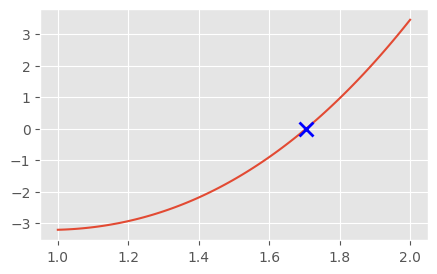

In [4]:
fig, axes = plt.subplots(figsize=(5, 3))
def f(x):
    return x**3 - 5*np.sin(x)

x_left, x_right = 1, 2
x = sl.dichotomy(f, x_left, x_right)
print(f"Приближенное решение: {x}\nЗначение в этой точке: {f(x)}")

N_x = 100
x_arr = np.linspace(x_left, x_right, N_x)
axes.plot(x_arr, f(x_arr));
axes.plot(x, f(x), 'bx', markersize=10, markeredgewidth=2);

## Пример метода Ньютона

In [12]:
variables = [sp.Symbol('x'), sp.Symbol('y'), sp.Symbol('z')]
x = variables[0]
y = variables[1]
z = variables[2]

## 1D

In [ ]:
# 1-D
F = np.array([
        exp(1 - x**2) - 3*x**2 
    ])

# Начальное приближение
x0 = np.array([-0.8])

sl.NEWTON(F, x0)

C:\Users\User\AppData\Local\Temp\ipykernel_22228\890480166.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta = float(-F_val / J_val)


array([-0.72950221])

## 2D

In [ ]:
# 2-D
F = np.array([
        x - y**2,
       cos(x) - y
    ])

# Начальное приближение
x0 = np.array([0.5, 0.5])

sl.NEWTON(F, x0)

array([0.64171437, 0.80107077])

In [ ]:
# 2-D
F = np.array([
        x**2 + y**2 - 4,
        y - x**2 + 2*x - 1
    ])

# Начальное приближение
x0 = np.array([1.0, 1.0])

sl.NEWTON(F, x0)

array([1.85894413, 0.73778502])

## 3D

In [ ]:
# 3-D
F = np.array([
        x**2 + y**2 + z**2 - 14,
        x*y + y*z - 2*x - 1,
        exp(x/2) + cos(y) + z - 3
    ])
# Начальное приближение
x0 = np.array([1.0, 2.0, 3.0])

sl.NEWTON(F, x0)

array([ 2.76329815,  2.51698049, -0.17027197])

## Пример метода простой итерации

Приближенное решение: -0.7295022100095926
Значение в этой точке: -0.7295022100095927


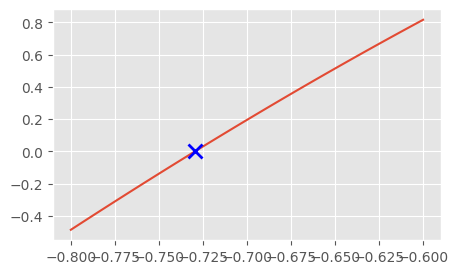

In [23]:
fig, axes = plt.subplots(figsize=(5, 3))
def f(x):
    return -np.sqrt((np.exp(1-x**2)/3))

def f_graf(x):
    return np.exp(1-x**2) - 3*x**2

x_left, x_right = -0.8, -0.6
x = sl.ITER_SIMPLE(f, (x_left + x_right)/2)

print(f"Приближенное решение: {x}\nЗначение в этой точке: {f(x)}")

N_x = 100
x_arr = np.linspace(x_left, x_right, N_x)
axes.plot(x_arr, f_graf(x_arr));
axes.plot(x, f_graf(x), 'bx', markersize=10, markeredgewidth=2);